$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [10]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;
import sklearn.mixture;

# ipython
import IPython;

# python
import os;
import random;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, 
                         (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.\
                You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);
        
    return render_func;

######################################################

# EECS 445:  Machine Learning

## Lecture 18:  GMMs & Hidden Markov Models

- Instructor:  **Jacob Abernethy**
- Date:  November 15, 2016

*Lecture Exposition:*  Benjamin Bray

# Gaussian Mixture Models

> Review

### Gaussian Mixture Models:  Specification

Recall from earlier the **Gaussian Mixture Model**:
$$
\begin{align}
\theta &= (\vec\pi, \vec\mu, \vec\Sigma) && \text{model parameters} \\
z_n &\sim \Cat[\pi]  && \text{cluster indicators} \\
x_n | z_n, \theta &\sim \mathcal{N}(\mu_{z_n}, \Sigma_{z_n}) && \text{base distribution}
\end{align}
$$

### GMM:  Complete Log Likelihood

The complete data log-likelihood for a single datapoint $(x_n, z_n)$ is
$$
\begin{align}
\log p(x_n, z_n | \theta)
&= \log \prod_{k=1}^K \pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)^{\mathbb{I}(z_n = k)} \\
&= \sum_{k=1}^K \mathbb{I}(z_n = k) \log \pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)
\end{align}
$$

### GMM:  Hidden Posterior

The hidden posterior for a single point $(x_n, z_n)$ can be found using Bayes' rule:
$$
\begin{align}
p(z_n = k | x_n, \theta)
&= \frac{P(z_n=k | \theta) p(x_n | z_n=k, \theta)}{p(x_N | \theta)} \\
&= \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{k'=1}^K \pi_{k'} \mathcal{N}(x_n | \mu_{k'}, \Sigma_{k'})}
\end{align}
$$

### GMM: Visual example
<img src="images/sample_gmm.png"/>

## Gaussian Mixture Model EM in Action

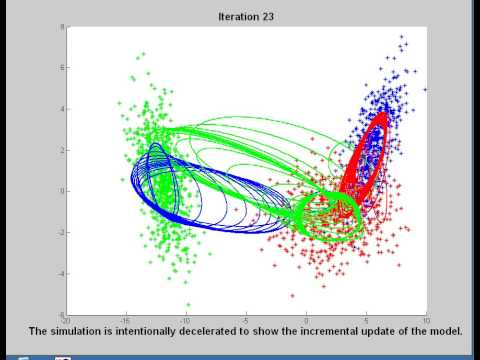

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('v-pq8VCQk4M')

### GMM:  E-Step

The **expected complete likelihood** is
$$
\begin{align}
E_q[ \log p(\X,Z|\theta)]
&= \sum_{n=1}^N \sum_{k=1}^K 
        E_q\big[ \mathbb{I}(z_n = k) \big] 
        \log \pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k) \\
&= \sum_{n=1}^N \sum_{k=1}^K 
        r_{nk} \log \pi_k
 + \sum_{n=1}^N \sum_{k=1}^K 
        r_{nk} \log \mathcal{N}(x_n \mid \mu_k, \Sigma_k)
\end{align}
$$

where $r_{nk} \equiv p(z_n = k \mid x_n,\theta_t)$ is the **responsibility** that cluster $k$ takes for datapoint $x_n$ after step $t$.

### GMM:  M-Step

During the M-Step, we optimize the lower bound with respect to $\theta=(\pi,\mu,\Sigma)$.  Verify that the correct updates are
$$
\begin{gather}
\pi_k = \frac{1}{N} \sum_{n=1}^N r_{nk} = \frac{r_k}{N}
\quad
\mu_k = \frac{\sum_{n=1}^N r_{nk} x_n}{r_k}
\\
\Sigma_k = \frac{\sum_{n=1}^N r_{nk} x_n x_n^T}{r_k} - \mu_k \mu_k^T
\end{gather}
$$

where $r_k = \sum_{n=1}^N r_{nk}$ is the *effective* sample size for cluster $k$.

# Markov Models

> Uses material from **[MLAPP]**

### Sequential Data

Some data has intrinsic sequential structure
- **Time Series:** Speech, EKGs, stock market, robot sensors, etc.
- **Spatial Data:** DNA, natural language, etc.

We could treat data points as iid samples
- e.g. "bag of words" assumption for spam classification
- But this is false!  We are ignoring valuable constraints in the data.

### Markov Models

A **Markov chain** is a series of random variables $X_1, \dots, X_N$ satisfying the *Markov property*:
> The future is independent of the past, given the present.
    $$
    p(x_n | x_1, \dots, x_{n-1}) = p(x_n | x_{n-1})
    $$
    
A chain is **stationary** if the transition probabilities do not change with time.

### Example:  [Random Shakespeare](http://www.cs.princeton.edu/courses/archive/spr05/cos126/assignments/markov.html)

```
DUKE SENIOR	Now, my co-mates and thus bolden'd, man, how now, monsieur Jaques,
	Unclaim'd of his absence, as the holly!
	Though in the slightest for the fashion of his absence, as the only wear.

TOUCHSTONE	I care not for meed!
	This I must woo yours: your request than your father: the time,
	That ever love I broke
	my sword upon some kind of men
	Then, heigh-ho! sing, heigh-ho! sing, heigh-ho! sing, heigh-ho! unto the needless stream;
	'Poor deer,' quoth he,
	'Call me not so keen,
	Because thou the creeping hours of the sun,
	As man's feasts and women merely players:
	Thus we may rest ourselves and neglect the cottage, pasture?

[Exit]
```

### Markov Models:  PGM

In [5]:
@pgm_render
def pgm_markov_chain():
    pgm = daft.PGM([6, 6], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("x1", r"$X_n$", 2, 2.5))
    pgm.add_node(daft.Node("x2", r"$X_2$", 3, 2.5))
    pgm.add_node(daft.Node("ellipsis", r" . . . ", 3.7, 2.5, 
                           offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("ellipsis_end", r"", 3.7, 2.5, 
                           offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("xN", r"$X_N$", 4.5, 2.5))

    # Add in the edges.
    pgm.add_edge("x1", "x2", head_length=0.08)
    pgm.add_edge("x2", "ellipsis", head_length=0.08)
    pgm.add_edge("ellipsis_end", "xN", head_length=0.08)
    
    return pgm;

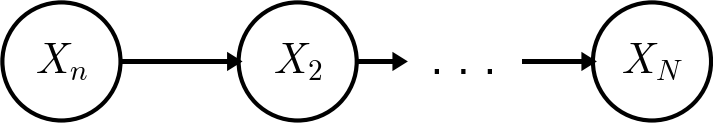

In [6]:
%%capture
pgm_markov_chain("images/pgm/markov-chain.png")

### Markov Models:  Joint Distribution

If a sequence has the Markov property, then the joint distribution factorizes according to
    $$
    p(x_1, \dots, x_N) = p(x_1) \prod_{n=2}^N p(x_n | x_{n-1})
    $$

### Example: Language Modeling

One important application is statistical **language models**.
- Bag-of-words assumption is inadequate
- Assume each word $X_t$ depends on the previous $n$ words

Can model longer-range dependencies
<table border=0px>
  <tr>
    <td>
*Zero-Order:* $P(X_t)$ <br>
*First-Order:* $P(X_t | X_{t-1})$<br>
*Second-Order:* $P(X_t | X_{t-1}, X_{t-2})$
    </td> 
    <td>
    <img src="images/2ndorder_markov.png" width=400px></td>
  </tr>
</table>

One we've learned an $n$th order Markov chain, we can use it to generate text!

### Example:  [Garkov Chain](http://joshmillard.com/garkov/)

<img src="images/garkov-1.png">
<img src="images/garkov-2.png">

### Markov Models:  Transition Matrix

Suppose $X_t \in \{1,\dots,K\}$ is discrete.  Then, a stationary chain with $N$ states can be described by a **transition matrix**, $A \in \R^{N \times N}$ where
    $$
    a_{ij} = p(X_t=j \mid X_{t-1}=i)
    $$

is the probability of transitioning from state $i$ to $j$.

> Each row sums to one, $\sum_{j=1}^K A_{ij} = 1$, so $A$ is a *row-stochastic matrix*.

### Markov Models:  Transition Diagram

Transitions between states can be represented as a graph:

<img src="images/murphy-fig174-markov.png">

> The graph above is *not* a Bayesian network!
> Instead, the nodes in this graph represent states that each $X_i$ can take.

<span style="color:gray; font-size:10px; float:right">(Figure 17.4b from **[MLAPP]**)</span>

### Markov Models:  State Vectors

Consider a row vector $x_t \in \R^{1 \times K}$ with entries $x_{tj} = p(X_t = j)$.  Then,

$$
    \begin{align}
    p(X_t = j)
    &= \sum_{i=1}^K p(X_t = j \mid X_{t-1} = i) p(X_{t-1} = i) \\
    &= \sum_{i=1}^K A_{ij} x_{t-1,i} \\
    \end{align}
$$

Therefore, we conclude $x_t = x_{t-1} A$.

(Note $\sum_{j=1}^K x_{tj} = 1$.)

### Markov Models:  Matrix Powers

Since $x_t = x_{t-1} A$, this suggests that in general,
    $$
    x_{t} = x_{t-1} A = x_{t-2} A^2 = \cdots x_{0} A^t
    $$
If we know the initial state probabilities $x_0$, we can find the probabilities of landing in any state at time $t > 0$.

### Example:  Weather

Suppose the weather is either $R=\text{Rainy}$ or $S=\text{Sunny}$,
    $$
    A = \begin{bmatrix}
        0.9 & 0.1 \\
        0.5 & 0.5
    \end{bmatrix}
    $$

<img src="images/markov-chain-weather.png">

<span style="color:gray; font-size:10px; float:right">(Taken from [Wikipedia](https://en.wikipedia.org/wiki/Examples_of_Markov_chains#A_very_simple_weather_model))</span>

### Example:  Weather

Suppose today is sunny, $x_0 = \begin{bmatrix} 1 & 0 \end{bmatrix}$.  We can predict tomorrow's weather,
    $$
    x_1 = x_0 A = \begin{bmatrix} 0.9 & 0.1 \end{bmatrix}
    $$
The weather over the next several days will be
    $$
    \begin{align}
    x_2 &= x_1 A = \begin{bmatrix} 0.86 & 0.14 \end{bmatrix} \\
    x_3 &= x_2 A = \begin{bmatrix} 0.844 & 0.156 \end{bmatrix} \\
    x_4 &= x_3 A = \begin{bmatrix} 0.8376 & 0.1624 \end{bmatrix}
    \end{align}
    $$

> **Question:** What happens to $x_0 A^n$ as $n \rightarrow \infty$?

### Markov Chains:  Stationary Distribution

If we ever reach a stage $x$ where
    $$
    x = xA
    $$
then we have reached the **stationary distribution** of the chain.
- To find $x=v^T$, solve the eigenvalue problem $A^T v = v$
- Under certain conditions, the limiting distribution $\lim_{n \rightarrow \infty} x_0 A^n = x$
- Stationary distribution $x$ does not depend on the starting state $x_0$

## Break time!
![](images/garfield_dancing.gif)

# Hidden Markov Models

> Uses material from **[MLAPP]**

### Hidden Markov Models

Noisy observations $X_k$ generated from *discrete* hidden Markov chain $Z_k$.
$$
P(\vec{X}, \vec{Z}) = P(Z_1) P(X_1 \mid Z_1) \prod_{k=2}^T P(Z_k \mid Z_{k-1}) P(X_k \mid Z_k)
$$

In [31]:
@pgm_render
def pgm_hmm():
    pgm = daft.PGM([7, 7], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("Z1", r"$Z_1$", 1, 3.5))
    pgm.add_node(daft.Node("Z2", r"$Z_2$", 2, 3.5))
    pgm.add_node(daft.Node("Z3", r"$\dots$", 3, 3.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("Z4", r"$Z_T$", 4, 3.5))

    pgm.add_node(daft.Node("x1", r"$X_1$", 1, 2.5, observed=True))
    pgm.add_node(daft.Node("x2", r"$X_2$", 2, 2.5, observed=True))
    pgm.add_node(daft.Node("x3", r"$\dots$", 3, 2.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("x4", r"$X_T$", 4, 2.5, observed=True))


    # Add in the edges.
    pgm.add_edge("Z1", "Z2", head_length=0.08)
    pgm.add_edge("Z2", "Z3", head_length=0.08)
    pgm.add_edge("Z3", "Z4", head_length=0.08)

    pgm.add_edge("Z1", "x1", head_length=0.08)
    pgm.add_edge("Z2", "x2", head_length=0.08)
    pgm.add_edge("Z4", "x4", head_length=0.08)
    
    return pgm;

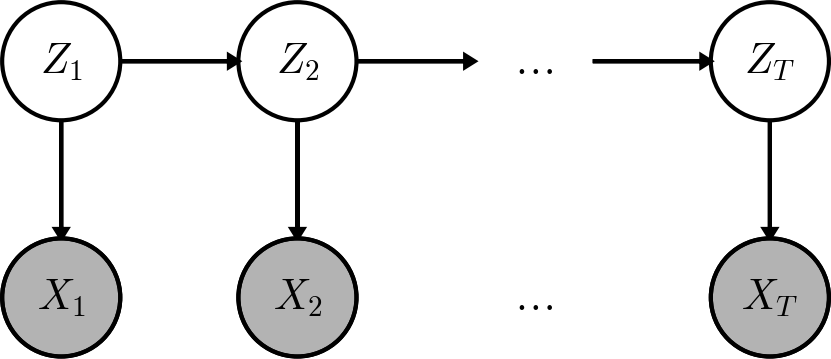

In [32]:
%%capture
pgm_hmm("images/pgm/hmm.png")

### HMM:  Parameters

For a Hidden Markov Model with $N$ hidden states and $M$ observed states, there are three *row-stochastic* parameters $\theta=(A,B,\pi)$,
- Transition matrix  $A \in \R^{N \times N}$
    $$
    A_{ij} = p(Z_t = j | Z_{t-1} = i)
    $$
- Emission matrix $B \in \R^{N \times M}$
    $$
    B_{jk} = p(X_t = k | Z_t = j)
    $$
- Initial distribution $\pi \in \R^N$,
    $$
    \pi_j = p(Z_1 = j)
    $$

### HMM:  Filtering Problem

**Filtering** means to compute the current *belief state* $p(z_t | x_1, \dots, x_t,\theta)$.
    $$
    p(z_t | x_1,\dots,x_t) = \frac{p(x_1,\dots,x_t,z_t)}{p(x_1,\dots,x_t)}
    $$
- Given observations $x_{1:t}$ so far, infer $z_t$.
- *Example*:  Estimate robot position given previous sensor readings.

> Solved by the **forward algorithm**.

### HMM:  Filtering Problem

As an example of filtering, consider **robot localization**, in which we 
- estimate the current location $z_t$
- given **noisy** sensor readings $x_1,\dots,x_t$.

<img src="images/murphy-fig183-filtering.png">

<span style="color:gray; font-size:10px; float:right">(Figure 18.3a from **[MLAPP]**)</span>

## How do we infer values of hidden variables?

- One of the most challenging part of HMMs is to try to "predict" what are the values of the hidden variables $z_t$, having observed all the $x_1, \ldots, x_T$.
- Computing $p(z_t \mid \X)$ is known on *smoothing*. More on this soon.
- But it turns out that this probability can be computed from two other quantities:
    - $p(x_1,\dots,x_t,z_t)$, which we are going to label $\alpha_t(z_t)$
    - $p(x_{t+1},\dots,x_{T} | z_t)$, which we are going to label $\beta_t(z_t)$

### HMM:  Forward Algorithm

The **forward algorithm** computes $\alpha_t(z_t) \equiv p(x_1,\dots,x_t,z_t)$.

> Looks kinda hard to compute this probability, there are a lot of variables! Maybe it can be computed recursively? **Yes!**

$$
    \begin{align}
    \alpha_t(z_t)
    &= \sum_{z_{t-1}} p(x_1, \dots, x_t, z_{t-1}, z_t) \\
    &= \sum_{z_{t-1}} p(x_1, \dots, x_{t-1}, z_{t-1}) p(z_t | z_{t-1}) p(x_t | z_t) \\
    &= p(x_t | z_t) \sum_{z_{t-1}} \alpha_{t-1}(z_{t-1}) p(z_t | z_{t-1})\\
    &= B_{z_t,x_t} \sum_{z_{t-1}} \alpha_{t-1}(z_{t-1}) A_{z_{t-1}, z_t}
    \end{align}
$$

> Recursion starts from the *front* of the chain.
> (Suggestion: you need to work out the above recursion on your own, it's a really important exercise)

### HMM:  Backward Algorithm

The **backward algorithm** computes $\beta_t(z_t) \equiv p(x_{t+1},\dots,x_{T} | z_t)$,
> Again, maybe we can try to compute this recursively?

$$
    \begin{align}
    \beta(z_t)
    &= \sum_{z_{t+1}} p(x_{t+1},\dots,x_{T},z_{t+1} | z_t) \\
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}, \dots, x_T |z_{t+1}, z_t)\\
        (\text{since } x_{t+1:T} \perp z_t \mid z_{t+1}) \quad 
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}, \dots, x_T |z_{t+1})\\
        (\text{since } x_{t+2:T} \perp x_{t+1} \mid z_{t+1}) \quad 
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}|z_{t+1})  p(x_{t+2}, \dots, x_T |z_{t+1})\\
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}|z_{t+1}) \beta_{t+1}(z_{t+1}) \\
    &= \sum_{z_{t+1}} A_{z_t, z_{t+1}} B_{z_{t+1}, x_{t+1}} \beta_{t+1}(z_{t+1})
    \end{align}
$$

> Recursion starts from the *back* of the chain.
> (Suggestion: you need to work out the above recursion on your own, it's a really important exercise)

### HMM:  Smoothing Problem

Compute $p(z_t | \X)$ offline, given all observations.  
- Retroactively infer $z_t$.  (Hindsight!)

We can break the chain into two parts, the *past* and *future*:
    $$
    \begin{align}
    p(z_t | \X)
    &= p(x_{1:t}, z_t, x_{t+1:T}) \frac{1}{p(\X)} \\
    &= p(x_{1:t}, z_t) p(x_{t+1:T} | x_{1:t}, z_t)\frac{1}{p(\X)} \\
    &= p(x_{1:t}, z_t) p(x_{t+1:T} | z_t)\frac{1}{p(\X)}
    \end{align}
    $$
**Exercise**: How did we get that last line?

### HMM:  Smoothing Problem

Overall, the **smoothing problem** is to compute
$$
\begin{align*}
    \gamma_t(j) \equiv p(z_t = j \mid \X) 
    & = \frac{p(\X \mid z_t = j)p(z_t = j)}{p(\X)} \\
    & = \frac{p(\X_{1:t} \mid z_t = j) p(\X_{t+1:T} | z_t=j) p(z_t = j)}{p(\X)} \\
    & = \frac{\alpha_t(j) \beta_t(j)}{p(\X)} = \frac{\alpha_t(j) \beta_t(j)}{\sum_k \alpha_t(k)\beta_t(k)}
\end{align*}
$$
It is an easy exercise to check that, for any $t$, $p(\X) = \sum_k \alpha_t(k)\beta_t(k)$.

We solve this via the **forward-backward algorithm**, where
- $\alpha_t(z_t) \equiv p(x_1,\dots,x_t,z_t)$ is found with the **forward algorithm**
- $\beta_t(z_t) \equiv p(x_{t+1},\dots,x_{T} | z_t)$ is found with the **backward algorithm**



### HMM:  Decoding Problem

**Decoding** computes the most probable state sequence, given observations.
    $$
    \vec{z}^* = \arg\max_{z_1,\dots,z_T} p(z_1,\dots,z_T | x_1, \dots, x_T, \theta)
    $$

> The decoding problem is solved by the **Viterbi algorithm**, which uses dynamic programming.  See **[PRML]** or **[MLAPP]** for more details.

### Viterbi Algorithm

* Viterbi is another recursive procedure for computing the most likely sequence of hidden states.
* We define $V_t(z_t)$ to be the probability of the most likely sequence of states up to time $t$ *that ended in state* $z_t$, given observed data
* These $V(z_t)$ values satisfies the recursion:

\begin{align}
V_1(j) & = p(x_1 \mid z_1=j) = B_{x_1, j}\\
V_{t+1}(j) & = p(x_{t+1} \mid z_{t+1} = j) \max_{k} \bigg\{ V_{t}(k) p(z_{t+1} = j \mid z_t = k) \bigg\}\\
& = B_{x_{t+1},j} \max_{k} \bigg\{ V_{t}(k) A_{j,k} \bigg\}
\end{align}

* Can be computed very quickly!


### HMM:  Part-of-Speech Tagging

In English, some words can have multiple parts of speech.  For instance,

- Business is going **well** (*Adverb*).
- All is **well** with us (*Adjective*).
- **Well**, who would have thought he could do it? (*Interjection*)
- The **well** was drilled fifty meters deep. (*Noun*)
- Tears **well** up in my eyes. (*Verb*)

<span style="color:gray; font-size:10px; float:right">(Example taken from [here](http://english.stackexchange.com/questions/46277/what-word-can-fulfill-the-most-parts-of-speech).)</span>

### HMM:  Part-of-Speech Tagging

We can use a Hidden Markov Model to **disambiguate** the part of speech using context clues!
- Hidden states $z_t$ are parts-of-speech
- Observed states $x_t$ are words

Certain sequences of POS tags are unlikely.  This allows us to infer the correct tags!

### HMM:  Learning Problem

It is usually necessary to **learn** the model parameters $\theta = (A,B,\pi)$ from data.
- Given observations $\mathcal{X} = \{ x_1, \dots, x_T \}$
- Given model dimensions $N$ and $M$
- Find parameters that best fit the data

> The learning problem is solved by the **Baum-Welch algorithm**, a special case of expectation maximization.

### Recall:  Expectation-Maximization

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Write down an expression for 
    $$
    Q(\theta_t, \theta) = E_{q}[ \log p(\X,Z | \theta) ] \quad \quad \text{ where } q = q(\cdot | \theta_t)
    $$
</div><div>
**M-Step:** Maximize the auxiliary function,
    $$
    \theta_{t+1}
    = \arg\max_\theta Q(\theta_t, \theta)
    $$
</div>
</div>

> Recall $q_t(Z) = p(Z|\X,\theta_t)$

### HMM:  Complete-Data Log-Likelihood

The joint likelihood of the hidden and observed states is

$$
\begin{align}
\log p(x_{1:T}, z_{1:T} | \theta)
&= \log \left[ p(z_1|\pi)
    \prod_{t=2}^T p(z_t | z_{t-1}, A)
    \prod_{t=1}^T p(x_t | z_t, B) \right] \\
&=  \log p(z_1|\pi)
    + \sum_{t=2}^T \log p(z_t | z_{t-1}, A) \\
    & \qquad \qquad + \sum_{t=1}^T \log p(x_t | z_t, B) 
\end{align}
$$

### HMM:  Complete-Data Log-Likelihood

Each term of the complete-data log-likelihood is:

$$
\begin{align}
\log p(z_1 | \pi)
    &= \sum_{j=1}^N \mathbb{I}(z_t=j) \log \pi_j \\
\log p(z_t | z_{t-1}, A)
    &= \sum_{i=1}^N \sum_{j=1}^N 
        \mathbb{I}(z_{t-1}=i)\mathbb{I}(z_t=j) \log A_{ij} \\
\log p(x_t | z_t, B)
    &= \sum_{j=1}^N 
        \mathbb{I}(z_t=j) \log B_{j,x_t} 
\end{align}
$$

### HMM:  Expected Complete Likelihood

The expected complete likelihood $Q(\theta_t, \theta)$ is

$$
\begin{align}
Q(\theta_t,\theta)
&= E_q[ \log p(\X,Z|\theta) ] \\
&= E_q[ \log p(z_1|\pi) ]
    + E_q\left[ \sum_{t=2}^T \log p(z_t | z_{t-1}, A) \right]\\
    &\qquad + E_q\left[ \sum_{t=1}^T \log p(x_t | z_t, B) \right]
\end{align}
$$

### HMM:  Expected Complete Likelihood

Fixing $t > 1$, and taking expectations with respect to $q(Z) = p(Z|\X,\theta)$,

$$
\begin{align*}
E_q[\log p(z_1 | \pi)]
    &= \sum_{j=1}^N q(z_1=j) \log \pi_j \\
E_q[\log p(z_t | z_{t-1}, A)]
    &= \sum_{i=1}^N \sum_{j=1}^N 
        q(z_{t-1}=i, z_t=j) \log A_{ij} \\
E_q[\log p(x_t | z_t, B)]
    &= \sum_{j=1}^N 
        q(z_t=j) \log B_{j, x_t} 
\end{align*}
$$


### HMM:  Baum-Welch

- The **E-Step** consists of computing the $q$ terms from the previous slide, which can all be computed using the **forward-backward algorithm**!

- The **M-Step** consists of normalizing the expected transition and emission counts
    - Similar to MLE for complete data
    - Requires some careful calculations. See details on next slide.

You must compute the key quantities for $q()$ using the forward-backward algorithm. In the E step you can assume the parameters $\theta = (A, B, \pi)$, so we'll drop dependence on $\theta$.
1. First note that $q(z_t=j) = p(z_t = j \mid \X, \theta) = \gamma_t(j)$ which we computed above.
1. We then compute $q(z_{t-1}=i, z_t=j) = p(z_{t-1}=i, z_t=j | \X, \theta)$. 
$$
\begin{align*}
    p(z_{t-1}, z_t | \X, \theta)
    & = \frac{p(\X \mid z_t, z_{t-1})p(z_t, z_{t-1})}{p(\X)} \\
    & = \frac{p(\X_{1:t-1} \mid z_t, z_{t-1}) p(\X_{t:T} | z_t, z_{t-1}) p(z_t, z_{t-1})}{p(\X)} \\
    & = \frac{p(\X_{1:t-1} \mid z_{t-1}) p(\X_{t:T} | z_t) p(z_t, z_{t-1})}{p(\X)} \\
    & = \frac{p(\X_{1:t-1}, z_{t-1}) p(x_t \mid z_t) p(\X_{t+1:T} | z_t) p(z_t, z_{t-1})}{p(z_{t-1})p(\X)} \\
    & = \frac{\alpha_{t-1}(z_{t-1}) \beta_t(z_t) p(z_t \mid z_{t-1}) p(x_t \mid z_t)}{p(\X)} \\
    & = \frac{\alpha_{t-1}(z_{t-1}) \beta_t(z_t) A_{z_{t-1}, z_t} B_{z_t, x_t}}{\sum_k \alpha_t(k)\beta_t(k)}
\end{align*}
$$